# Applied Machine Learning: Regression

This notebook was created to predict House Sales in King County, USA. The dataset includes homes sold between May 2014 and May 2015.

This assignment is part of Singapore Polytechnic's `IT8302 - Applied Machine Learning`. 

# Preamble

In [1]:
# set display to 80% of the screen
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# import libraries
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

## Load Data

In [3]:
df = pd.read_csv('kc_house_data 2.csv')

In [4]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Part 1: EDA

Below are columns we'll see in the training dataset and the data they represent:
- `id` - Unique ID for each home sold
- `date` - Date of the home sale
- `price` - Price of each home sold
- `bedrooms` - Number of bedrooms
- `bathrooms` - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- `sqft_living` - Square footage of the apartments interior living space
- `sqft_lot` - Square footage of the land space
- `floors` - Number of floors
- `waterfront` - A dummy variable for whether the apartment was overlooking the waterfront or not
- `view` - An index from 0 to 4 of how good the view of the property was:
    - 0 = No view, 1 = Fair 2 = Average, 3 = Good, 4 = Excellent
- `condition` - An index from 1 to 5 on the condition of the apartment
    -  1 = Poor- Worn out, 2 = Fair- Badly worn, 3 = Average, 4 = Good, 5= Very Good
- `grade` - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
- `sqft_above` - The square footage of the interior housing space that is above ground level
- `sqft_basement` - The square footage of the interior housing space that is below ground level
- `yr_built` - The year the house was initially built
- `yr_renovated` - The year of the house’s last renovation
- `zipcode` - What zipcode area the house is in
- `lat` - Lattitude
- `long` - Longitude
- `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
- `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [7]:
# shape of the dataframe
df.shape

(21613, 21)

In [8]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [9]:
def num_missing_cols(df):
    for i in df.columns:
        print(f'{i}: {df[i].isnull().sum()}')
    print()
        
num_missing_cols(df)

id: 0
date: 0
price: 0
bedrooms: 0
bathrooms: 0
sqft_living: 0
sqft_lot: 0
floors: 0
waterfront: 0
view: 0
condition: 0
grade: 0
sqft_above: 0
sqft_basement: 0
yr_built: 0
yr_renovated: 0
zipcode: 0
lat: 0
long: 0
sqft_living15: 0
sqft_lot15: 0



In [10]:
# check for duplicates
df.duplicated().sum()

0

Looking at the dataset, we find that:
- there are 21,613 samples
- none of the columns have missing values
- there are no duplicated rows
- other than `date`, the rest of the columns are either float or int dtypes
- the lowest priced house is USD75,000, the median house price is USD450,000 and the most expensive house is USD7,700,000

Now let's look at the price distribution:

Text(0.5, 1.0, 'House Price Distribution')

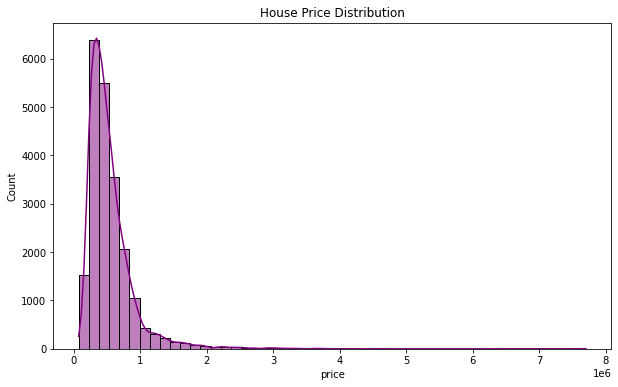

In [11]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='price', color='purple', bins=50, kde=True)
plt.title("House Price Distribution")

Text(0.5, 1.0, 'LatLong Map of King County Houses')

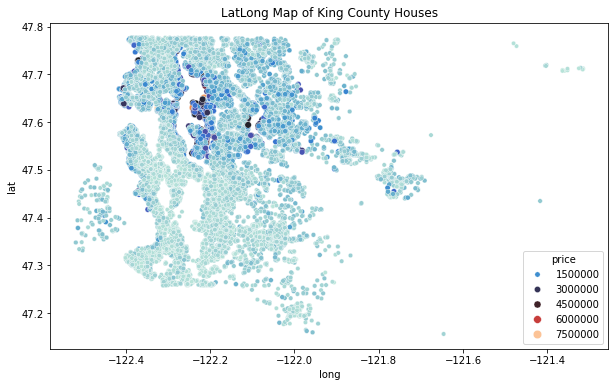

In [12]:
# latitude and longitude of the houses
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='long', y='lat', hue='price', palette='icefire',size='price')
plt.title("LatLong Map of King County Houses")

Next, we let's see which features have stronger correlations with the house price:

zipcode         -0.053203
long             0.021626
condition        0.036362
yr_built         0.054012
sqft_lot15       0.082447
sqft_lot         0.089661
yr_renovated     0.126434
floors           0.256794
waterfront       0.266369
lat              0.307003
bedrooms         0.308350
sqft_basement    0.323816
view             0.397293
bathrooms        0.525138
sqft_living15    0.585379
sqft_above       0.605567
grade            0.667434
sqft_living      0.702035
price            1.000000
Name: price, dtype: float64

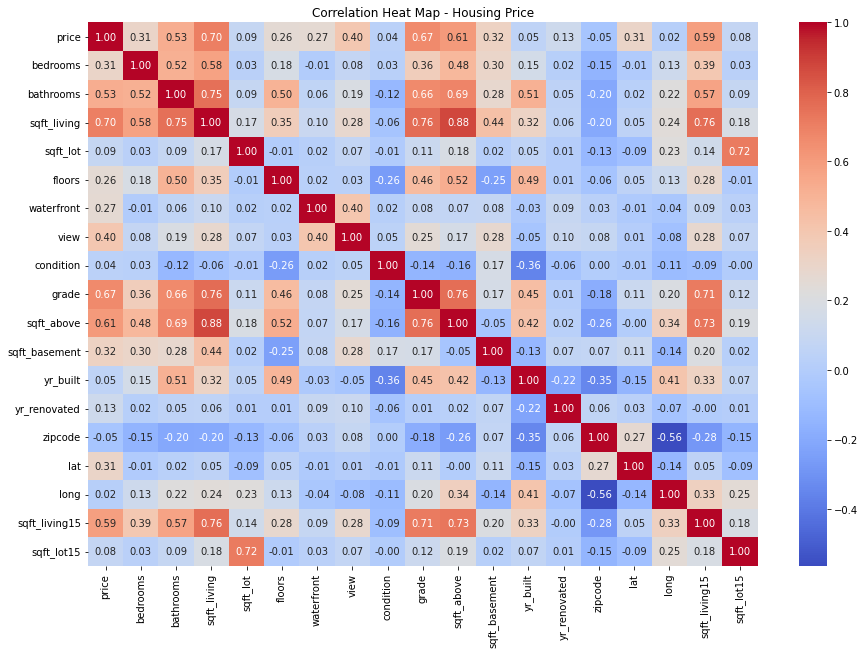

In [13]:
# heatmap of the correlation between the features excluding the id and zipcode column
plt.figure(figsize=(15,10))
sns.heatmap(df.drop(columns=['id','date'], axis=1).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heat Map - Housing Price')

df.drop(columns=['id','date'], axis=1).corr()['price'].sort_values()

Features that have stronger correlations with house prices include:
- `waterfront`
- `bedrooms`   
- `sqft_basement`
-  `view`
- `bathrooms`
- `sqft_living15`
- `sqft_above`
- `grade`
- `sqft_living`

Below we display the unique values for features with notable correlations (we left out the ones relating to sqft as there would be too many).

In [14]:
variables = ['waterfront', 'bedrooms', 'view', 'bathrooms', 'grade']
subset_df = df[variables]

for col in subset_df.columns:
    unique_values = subset_df[col].unique()
    print(f"Unique values for '{col}': {unique_values}")
    print()

Unique values for 'waterfront': [0 1]

Unique values for 'bedrooms': [ 3  2  4  5  1  6  7  0  8  9 11 10 33]

Unique values for 'view': [0 3 4 2 1]

Unique values for 'bathrooms': [1.   2.25 3.   2.   4.5  1.5  2.5  1.75 2.75 3.25 4.   3.5  0.75 4.75
 5.   4.25 3.75 0.   1.25 5.25 6.   0.5  5.5  6.75 5.75 8.   7.5  7.75
 6.25 6.5 ]

Unique values for 'grade': [ 7  6  8 11  9  5 10 12  4  3 13  1]



Here we use historgrams to display the distrbutions of all the features (other than latitude, longitude, and zip code).

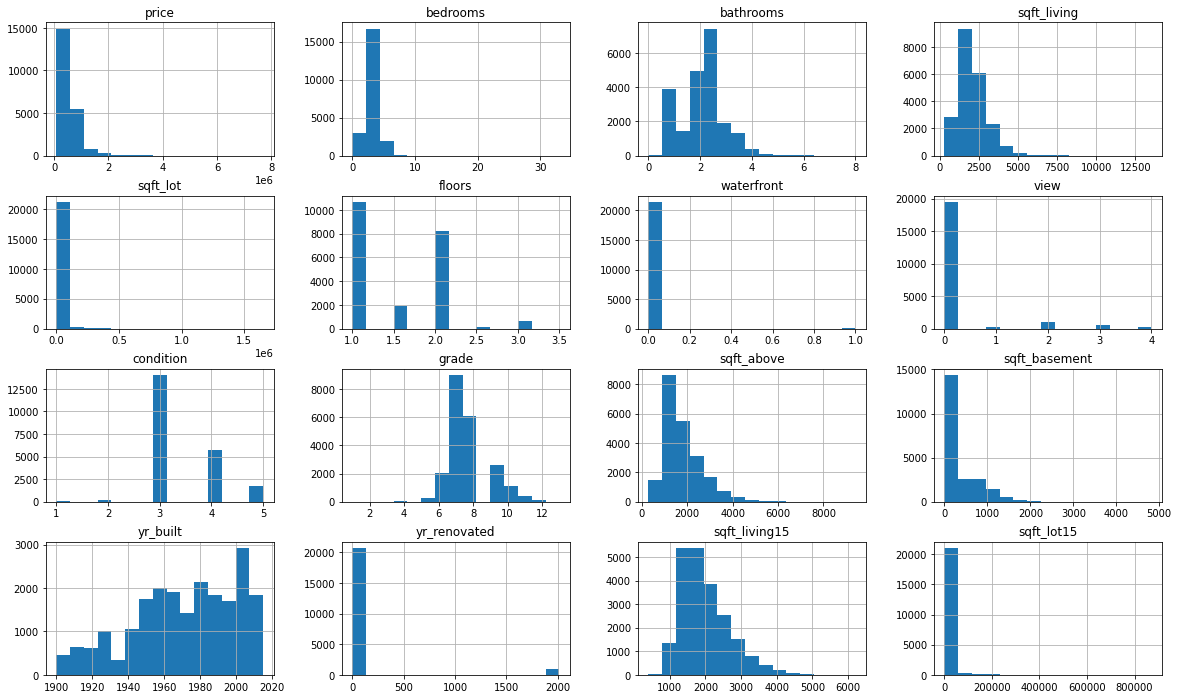

In [15]:
df.drop(columns=['id','date','lat', 'long', 'zipcode'], axis=1).hist(bins=15, figsize=(20,12), layout=(4, 4))
plt.show()

In [16]:
# extract categorical and numerical features
cat_features = ['condition','grade','view','floors','bedrooms','bathrooms','waterfront']
num_features = list(set(df.drop(columns=['id','date','lat', 'long', 'zipcode'], axis=1).columns)  - set(cat_features))

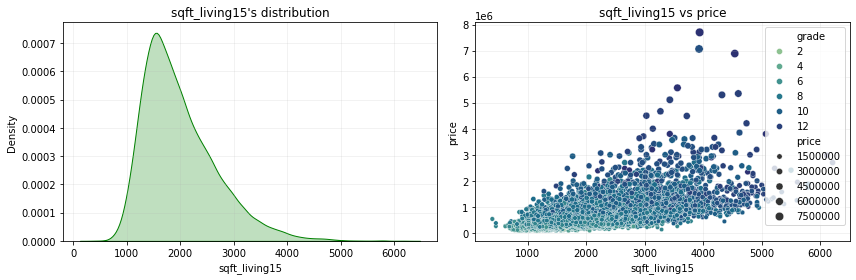

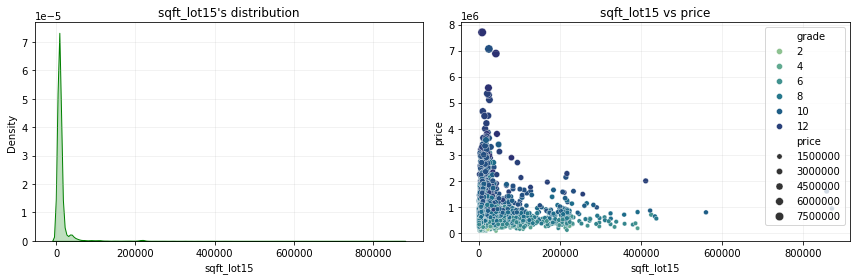

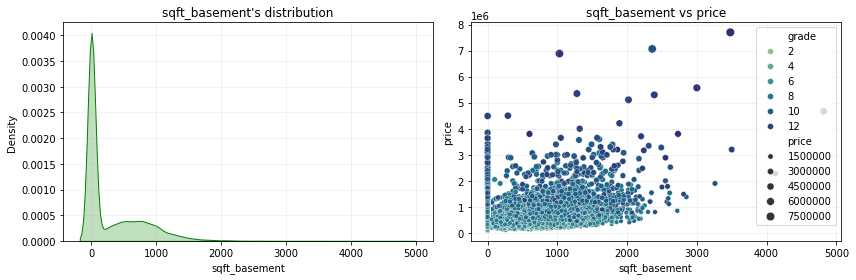

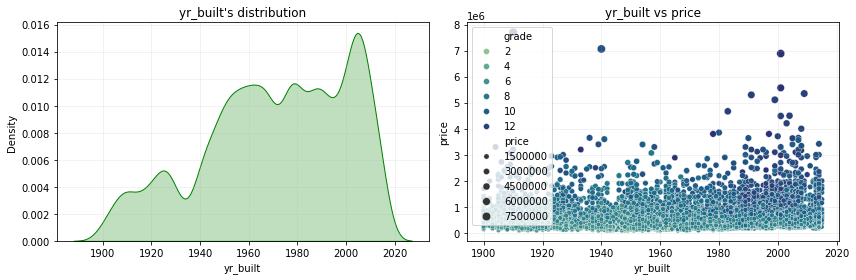

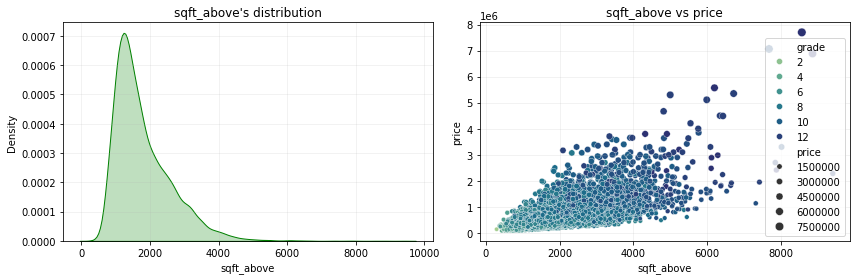

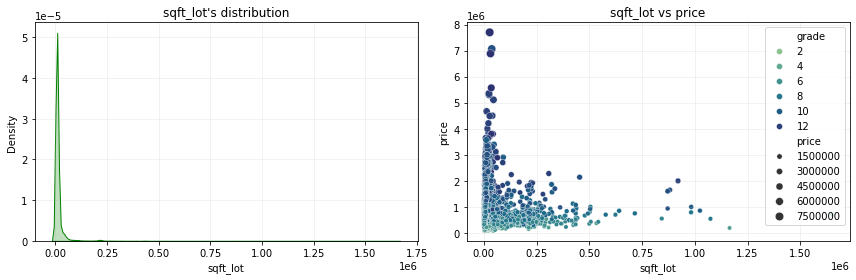

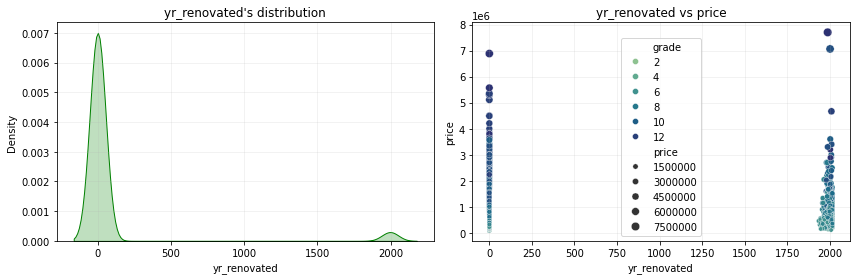

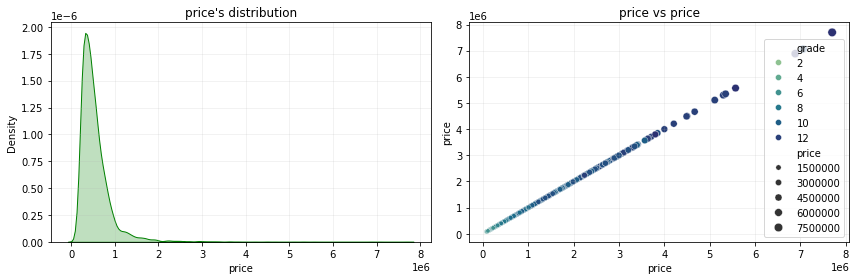

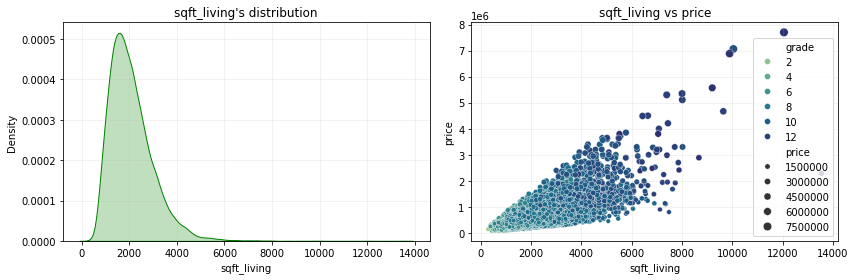

In [17]:
# visualize numerical features' distrbution and relationship with target variable price
for feature in num_features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # distribution plot
    sns.kdeplot(df[feature], fill=True, ax=axes[0], color='green')
    axes[0].grid(alpha=0.2)
    axes[0].set_title(f'{feature}\'s distribution', fontdict={'fontsize': 12})
    
    # scatter plot
    sns.scatterplot(data=df, x=feature, y='price', ax=axes[1], hue='grade', palette='crest', size='price')
    axes[1].grid(alpha=0.2)
    axes[1].set_title(f'{feature} vs price', fontdict={'fontsize': 12})
    
    plt.tight_layout()
    plt.show()

# Part 2: Feature Engineering

In this section, we will be transforming existing features and creating new ones in preparation for our machine learning model.

## 2.1 Date

In [18]:
# feature engineer date column, extract year and month for separate new feature
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda date: date.year)
df['month'] = df['date'].apply(lambda date: date.month)

In [19]:
# feature engineering the year column
df['house_age'] = df['year'] - df['yr_built']

# feature engineering the yr_renovated column
df['yrs_since_renovation'] = df['year'] - df['yr_renovated']

In [20]:
# drop columns
df.drop(['date','yr_renovated','yr_built'], axis=1, inplace=True)

# add new features to num_features list
num_features.extend(['house_age', 'yrs_since_renovation'])
num_features.extend(['house_age', 'yrs_since_renovation'])

## 2.2 Feature Transformation

We'll drop the columns we won't need for model training:

In [21]:
# drop columns
drop_cols = ['id', 'lat', 'long', 'zipcode','month']

df.drop(columns=drop_cols, axis=1, inplace=True) 

Next, in preparation for model training, we will transform the features using:
- Standard scaling for numeric features
- One-hot encoding for categorical features

In [22]:
num_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                'sqft_above', 'sqft_basement', 'sqft_living15',
                'sqft_lot15', 'house_age','yrs_since_renovation']

cat_features = ['waterfront', 'view', 'condition', 'grade', 'year']

In [23]:
# create an instance of StandardScaler
scaler = StandardScaler()

# fit and transform the specified columns in df
scaled_features = scaler.fit_transform(df[num_features])

# replace the original columns with the scaled values
df[num_features] = scaled_features

In [24]:
encoded_features = []

for feature in cat_features:
    # use on-hot encoding for categorical features
    encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
    n = df[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df.index
    encoded_features.append(encoded_df)
    
# concatenate all encoded features into a single dataframe
encoded_features_df = pd.concat(encoded_features, axis=1)

# concatenate the encoded features with the original dataframe
df = pd.concat([df, encoded_features_df], axis=1)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,year_1,year_2
0,221900.0,-0.398737,-1.447464,-0.979835,-0.228321,-0.915427,0,0,3,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,538000.0,-0.398737,0.175607,0.533634,-0.189885,0.936506,0,0,3,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,180000.0,-1.473959,-1.447464,-1.426254,-0.123298,-0.915427,0,0,3,6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,604000.0,0.676485,1.149449,-0.130550,-0.244014,-0.915427,0,0,5,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,510000.0,-0.398737,-0.149007,-0.435422,-0.169653,-0.915427,0,0,3,8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Below are the finalized columns we'll use for  machine learning algorithms:

In [25]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'sqft_lot15', 'year', 'house_age',
       'yrs_since_renovation', 'waterfront_1', 'waterfront_2', 'view_1',
       'view_2', 'view_3', 'view_4', 'view_5', 'condition_1', 'condition_2',
       'condition_3', 'condition_4', 'condition_5', 'grade_1', 'grade_2',
       'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'grade_10', 'grade_11', 'grade_12', 'year_1', 'year_2'],
      dtype='object')

# Part 3: Model

We'll start off this section by splitting the dataset into dependent and independent variables:

In [26]:
# split dataset into dependent and independent variables
X = df.drop('price', axis=1)
y = df['price']

Next we separate the dataset into training and testing sets.

In [27]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We then create a helper function that will help us evaluate our selected models.

Because we want to assess the models' accuracy, error magnitude, and predictive power, the metrics we've chosen are:
- mean absolute error
- mean squared error
- root mean squared error
- R squared

In [28]:
# helper function to evaluate model performance
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

Below is the list of classifiers we'll be using and and the reasons why we've chosen them:

- `Linear Regression`: fundamental regression model that assumes a linear relationship between the independent variables and the dependent variable; suitable for establishing baseline performance and understanding feature impacts in a straightforward manner.

- `Lasso`: Lasso (Least Absolute Shrinkage and Selection Operator) adds L1 regularization to the linear regression, which helps in feature selection by shrinking less important feature coefficients to zero. This model is effective in dealing with high-dimensional data and preventing overfitting.

- `Ridge`: Ridge Regression adds L2 regularization to the linear regression, which penalizes large coefficients to prevent overfitting. It is well-suited for situations where multicollinearity exists among the predictor variables.

- `Decision Tree`: Decision Tree Regressor splits the data into subsets based on feature values, resulting in a tree-like model of decisions. It is capable of capturing non-linear relationships and interactions between features.

- `Random Forest Regressor`: Random Forest Regressor is an ensemble method that combines multiple decision trees to improve predictive accuracy and control overfitting. It is robust to outliers and provides good generalization performance.

- `XGBRegressor`: XGBRegressor (Extreme Gradient Boosting) is a powerful ensemble method that uses boosting to combine the predictions of multiple weak learners. It is known for its high performance and efficiency in handling large datasets with complex relationships.

- `AdaBoost Regressor`: AdaBoost Regressor (Adaptive Boosting) combines the predictions of multiple weak learners, typically decision trees, by focusing on the errors of previous learners. It enhances model accuracy by adaptively adjusting to difficult cases.

In [29]:
# initialize classifiers
lr = LinearRegression()
lasso = Lasso(max_iter=100000)
ridge = Ridge()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor(random_state=1)
xgb = XGBRegressor(random_state=1)
abr = AdaBoostRegressor(random_state=1)

In [30]:
# helper function to evaluate model performance
def evaluate_model_performance(model, model_name):
    # train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    model_train_mae, model_train_mse, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_mse, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    # Print model performance
    print(f"{model_name}")

    print('Model performance for Training set')
    print(f"- Mean Squared Error: {model_train_mse:.2f}")
    print(f"- Root Mean Squared Error: {model_train_rmse:.2f}")
    print(f"- Mean Absolute Error: {model_train_mae:.2f}")
    print(f"- R2 Score: {model_train_r2:.4f}")
    print()
    print('Model performance for Test set')
    print(f"- Mean Squared Error: {model_test_mse:.2f}")
    print(f"- Root Mean Squared Error: {model_test_rmse:.2f}")
    print(f"- Mean Absolute Error: {model_test_mae:.2f}")
    print(f"- R2 Score: {model_test_r2:.4f}")

In [31]:
evaluate_model_performance(lr, 'Linear Regression')

Linear Regression
Model performance for Training set
- Mean Squared Error: 41402425730.26
- Root Mean Squared Error: 203475.86
- Mean Absolute Error: 133260.58
- R2 Score: 0.6831

Model performance for Test set
- Mean Squared Error: 47011914105.53
- Root Mean Squared Error: 216822.31
- Mean Absolute Error: 138217.01
- R2 Score: 0.6890


In [32]:
evaluate_model_performance(lasso, 'Lasso Regression')

Lasso Regression
Model performance for Training set
- Mean Squared Error: 41402454406.03
- Root Mean Squared Error: 203475.93
- Mean Absolute Error: 133261.69
- R2 Score: 0.6831

Model performance for Test set
- Mean Squared Error: 47012755412.79
- Root Mean Squared Error: 216824.25
- Mean Absolute Error: 138217.55
- R2 Score: 0.6890


In [33]:
evaluate_model_performance(ridge, 'Ridge Regression')

Ridge Regression
Model performance for Training set
- Mean Squared Error: 41417295136.39
- Root Mean Squared Error: 203512.40
- Mean Absolute Error: 133321.85
- R2 Score: 0.6830

Model performance for Test set
- Mean Squared Error: 47028236869.84
- Root Mean Squared Error: 216859.95
- Mean Absolute Error: 138249.20
- R2 Score: 0.6889


In [34]:
evaluate_model_performance(dt, 'Decision Tree')

Decision Tree
Model performance for Training set
- Mean Squared Error: 11933594.12
- Root Mean Squared Error: 3454.50
- Mean Absolute Error: 153.20
- R2 Score: 0.9999

Model performance for Test set
- Mean Squared Error: 77643071439.77
- Root Mean Squared Error: 278645.06
- Mean Absolute Error: 162643.79
- R2 Score: 0.4864


In [35]:
evaluate_model_performance(rf, 'Random Forest')

Random Forest
Model performance for Training set
- Mean Squared Error: 4454925726.21
- Root Mean Squared Error: 66745.23
- Mean Absolute Error: 42176.33
- R2 Score: 0.9659

Model performance for Test set
- Mean Squared Error: 43694717195.27
- Root Mean Squared Error: 209032.81
- Mean Absolute Error: 120244.85
- R2 Score: 0.7110


In [36]:
evaluate_model_performance(xgb, 'XGBoost Regression')

XGBoost Regression
Model performance for Training set
- Mean Squared Error: 10784629757.03
- Root Mean Squared Error: 103849.07
- Mean Absolute Error: 78229.87
- R2 Score: 0.9175

Model performance for Test set
- Mean Squared Error: 46173500222.46
- Root Mean Squared Error: 214880.20
- Mean Absolute Error: 123413.81
- R2 Score: 0.6946


In [37]:
evaluate_model_performance(abr, 'AdaBoost Regression')

AdaBoost Regression
Model performance for Training set
- Mean Squared Error: 150619565673.87
- Root Mean Squared Error: 388097.37
- Mean Absolute Error: 352429.80
- R2 Score: -0.1529

Model performance for Test set
- Mean Squared Error: 164823530524.48
- Root Mean Squared Error: 405984.64
- Mean Absolute Error: 357634.71
- R2 Score: -0.0903


**Summary of results:**

- `Linear Regression`: showed moderate performance with an R² score of 0.6890 on the test set, indicating a linear relationship captures some but not all of the variance in the data.

- `Lasso Regression`: performed similarly to Linear Regression with an R² score of 0.6890 on the test set, suggesting minimal benefit from regularization in this case.

- `Ridge Regression`: showed comparable performance to Linear and Lasso Regression, with a test set R² score of 0.6889, indicating that ridge regularization does not significantly improve model fit.

- `Decision Tree`: exhibited high overfitting with an R² score of nearly 1.0 on the training set but a much lower R² score of 0.4864 on the test set, indicating poor generalization.

- `Random Forest`: provided the best performance with an R² score of 0.7110 on the test set, demonstrating its ability to handle non-linear relationships and interactions effectively.

- `XGBoost Regression`: achieved a strong R² score of 0.6946 on the test set, indicating good performance, though slightly below the Random Forest model. Its flexibility and robustness to overfitting make it a competitive choice.

- `AdaBoost Regression`: performed poorly with negative R² scores on both the training and test sets, indicating that it does not fit the data well.

# Part 4: XGBoost Regression

In this section, we will go deeper into XGBoost Regression and tune it further.

In [38]:
# untuned performance results
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(f"Accuracy of the model is {score:.2f}%")

Accuracy of the model is 69.46%


<Axes: xlabel='price'>

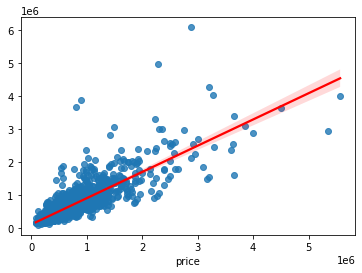

In [39]:
# visualized results
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"})

In [40]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
735,365000.0,4.683188e+05,-103318.84375
2830,865000.0,7.691590e+05,95841.00000
4106,1038000.0,9.704003e+05,67599.68750
16218,1490000.0,1.493329e+06,-3329.37500
19964,711000.0,6.840711e+05,26928.93750
...,...,...,...
13674,338000.0,4.010554e+05,-63055.43750
20377,673000.0,5.657582e+05,107241.81250
8805,285000.0,4.563372e+05,-171337.15625
10168,605000.0,5.324741e+05,72525.93750


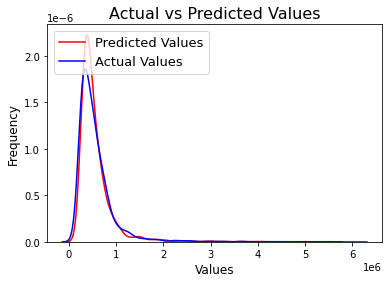

In [41]:
# visualizing prediction accuracy - distribution
sns.kdeplot(y_pred, color = 'r', label = 'Predicted Values')
sns.kdeplot(y_test, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

## Hyperparameter Tuning on XGBoost Regressor

In [56]:
# initiate XGB regressor
xgb = XGBRegressor()
xgb_param = {
    'n_estimators': [100, 500],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.5]
}

xgb_grid = GridSearchCV(xgb, xgb_param, cv=5, n_jobs=1)
xgb_grid.fit(X_train, y_train)

print(f"Best parameters for XGBRegressor: {xgb_grid.best_params_}")
print(f"Best score for XGBRegressor: {xgb_grid.best_score_}")

Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Best score for XGBRegressor: 0.7643431786063533


The hyperparameter tuning for XGBoost Regressor identified the best parameters as learning_rate of 0.1, max_depth of 3, and n_estimators of 500.

This optimized configuration achieved a cross-validated R² score of 0.7643, indicating a strong fit and potential for improved performance on unseen data.

In [57]:
# implement the best parameters for XGBRegressor
xgb = XGBRegressor(n_estimators=500,
                   max_depth=3,
                   learning_rate=0.1)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [58]:
# make predictions
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

# evaluate regressor on train and test dataset
xgb_train_mae, xgb_train_mse, xgb_train_rmse, xgb_train_r2 = evaluate_model(y_train, y_train_pred)

xgb_test_mae, xgb_test_mse, xgb_test_rmse, xgb_test_r2 = evaluate_model(y_test, y_test_pred)

print('XGBRegressor')
print('Model performance for Training set')
print(f"- Mean Squared Error: {xgb_train_rmse:.2f}")
print(f"- Root Mean Squared Error: {xgb_train_rmse:.2f}")
print(f"- Mean Absolute Error: {xgb_train_mae:.2f}")
print(f"- R2 Score: {xgb_train_r2:.4f}")
print()
print('Model performance for Test set')
print(f"- Mean Squared Error: {xgb_test_mse:.2f}")
print(f"- Root Mean Squared Error: {xgb_test_rmse:.2f}")
print(f"- Mean Absolute Error: {xgb_test_mae:.2f}")
print(f"- R2 Score: {xgb_test_r2:.4f}")

XGBRegressor
Model performance for Training set
- Mean Squared Error: 142658.79
- Root Mean Squared Error: 142658.79
- Mean Absolute Error: 103118.78
- R2 Score: 0.8442

Model performance for Test set
- Mean Squared Error: 44996311824.21
- Root Mean Squared Error: 212123.34
- Mean Absolute Error: 122966.28
- R2 Score: 0.7024


Text(0.5, 1.0, 'Feature Importance')

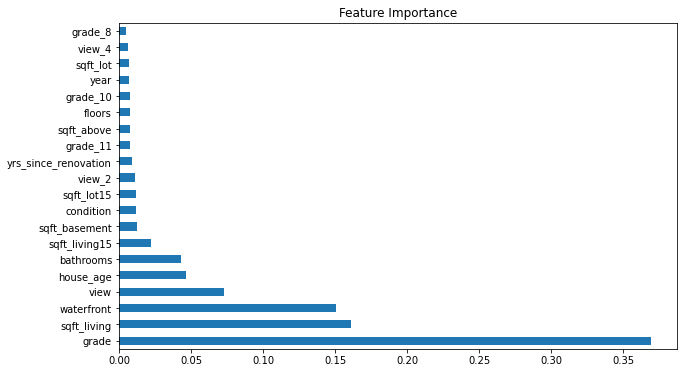

In [63]:
# Feature importance
plt.figure(figsize=(10,6))
feat_importances = pd.Series(xgb.feature_importances_, index=df.drop('price', axis=1).columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Feature Importance')

In [59]:
score = r2_score(y_test, y_test_pred)*100
print(f"Accuracy of the model is {score:.2f}%")

Accuracy of the model is 70.24%


# Conclusion

With the optimized configuration, the R² score registered an accuracy of 70.24%, slightly better than its untuned score of 69.46%. This improvement indicates that tuning the hyperparameters of the XGBoost Regressor resulted in a better fit to the data, reducing the prediction error. Additionally, the Mean Squared Error (MSE) and Mean Absolute Error (MAE) on the test set were also improved, showing the model’s ability to generalize to unseen data.

A closer examination of the feature importances revealed that the most significant predictors for house prices are `grade`, `sqft_living`, and `waterfront`.
- The grade feature, which reflects the overall quality of the construction and finishes of the house, was the most influential, highlighting the importance of build quality in determining home value.
- The sqft_living, indicating the total living space area, also played a crucial role, emphasizing that larger homes are valued higher.
- Lastly, the waterfront feature was significantly impactful, underscoring that houses with waterfront views or locations are highly sought after and command higher prices.

Overall, the XGBoost Regressor, with its optimized parameters, presents a reliable model for our regression problem, leveraging its advanced boosting techniques to handle the variability within datasets.